In [77]:
# y_hat = model(x)
# orders = strategy(y_hat)
# execute(orders)

# regression model => BTCUSDT => future log return


In [78]:
#data and analysis libraries
import polars  as pl            #Fast dataframes for financial  data
import numpy as np              #numerical computing library
from datetime  import datetime, timedelta #Date and time operations
import random

import torch                    #PyTorch framework
import torch.nn as nn           #Neural network modules
import torch.optim as optim     #Optimization algorithms
import researches                 #Model building and training  utilities
import importlib
importlib.reload(researches)

import altair as alt            #Interactive visualization library

import binance                  # Binance market data utilities
importlib.reload(binance)
print(researches.__file__)



c:\Users\Acer_\Desktop\Dev\quant trading strategy\researches.py


In [79]:
researches.set_seed(42) # control randomness, make the experiment repeatable, Ensure identical results each run

In [80]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)


polars.config.Config

In [81]:
#Trading pair symbol
sym = 'BTCUSDT'
#trading pair symbol
hist_data_window = 7 * 4 * 6
#time horizon of time series(time interval)
time_interval = '1h'
#max number of auto-regressive lags
max_lags = 4
# Forecast horizon in steps
forecast_horizon = 1
#Sharpe annualized rate (so it's indepndent of time frequency)
annualized_rate = researches.sharpe_annualization_factor(time_interval, 365, 24)


In [82]:
start_date = datetime(2024, 10, 29, 0, 0)
end_date = datetime(2025, 10, 9, 0, 0)
binance.download_date_range(sym, start_date, end_date)

In [83]:
ts = researches.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date) # load base on time interval and date
ts

Loading BTCUSDT: 100%|██████████| 346/346 [01:28<00:00,  3.89day/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6
…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8


In [84]:
ts

datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6
…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8


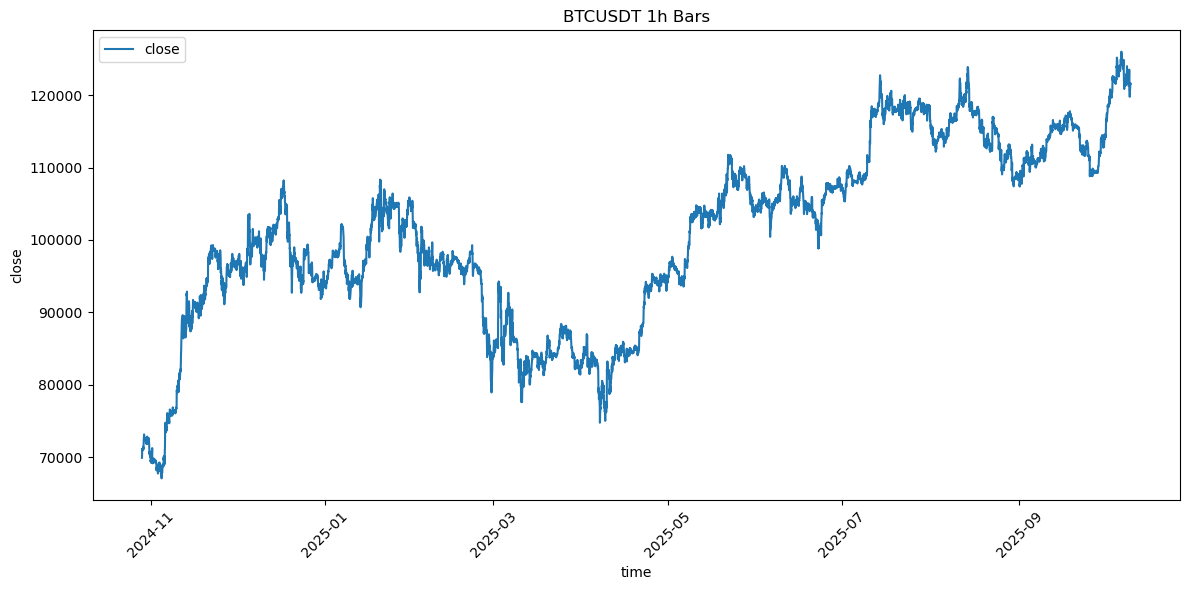

In [85]:
researches.plot_static_timeseries(ts, sym, 'close', time_interval)

In [86]:
alt.data_transformers.enable("vegafusion")
researches.plot_dyn_timeseries(ts, sym, 'close', time_interval)

alt.Chart(...)

Engineering Feature

In [87]:
price_time_series = pl.DataFrame({'price': [100.0, 120.0, 100.0]})
researches.plot_column(price_time_series, 'price')

alt.Chart(...)

# DELTA SHOW the price change, return percent change,  log_return  log percent change  and additive meaning the you can + and - see the if you gain or loss unlike the  return  

In [88]:
price_time_series.with_columns(
    pl.col('price').diff().alias('delta'),
    ((pl.col('price')-pl.col('price').shift())/pl.col('price').shift()).alias('return'),
    (pl.col('price')/pl.col('price').shift()).log().alias('log_return'),
)

price,delta,return,log_return
f64,f64,f64,f64
100.0,null,null,null
120.0,20.0,0.2,0.182322
100.0,-20.0,-0.166667,-0.182322


In [89]:
ts = ts.with_columns((pl.col('close')/pl.col('close').shift(forecast_horizon)).log().alias('close_log_return')) #add close log return on the ts
ts

datetime,open,high,low,close,close_log_return
datetime[μs],f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903
…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989


In [90]:
target = 'close_log_return'

lr = pl.col(target)
ts = ts.with_columns(
    lr.shift(forecast_horizon * 1).alias(f"{target}_lag_1"), #close_log_return 2024-10-29 01:00:00 -> push to next row on close_log_return_lag_1 2024-10-29 02:00:00 -> 0.004956
    lr.shift(forecast_horizon * 2).alias(f"{target}_lag_2"), #close_log_return 2024-10-29 01:00:00 -> push to next 2 row on close_log_return_lag_2 2024-10-29 03:00:00	-> 0.004956
    lr.shift(forecast_horizon * 3).alias(f"{target}_lag_3"), #close_log_return 2024-10-29 01:00:00 -> push to next 3 row on close_log_return_lag_3 2024-10-29 04:00:00	-> 0.004956
    lr.shift(forecast_horizon * 4).alias(f"{target}_lag_4"), #close_log_return 2024-10-29 01:00:00 -> push to next 4 row on close_log_return_lag_4 2024-10-29 05:00:00	-> 0.004956
)

ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null,null,null,null,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956,null,null,null,null
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465,-0.002613,0.009669,-0.011023,-0.001285
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222,0.002465,-0.002613,0.009669,-0.011023
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989,0.001222,0.002465,-0.002613,0.009669


In [91]:
ts = researches.add_lags(ts, target, max_lags, forecast_horizon) 
# dito yung mag gagawa tayo ng lag yung close_log_return ay ishishift natin sa next line na close_log_return_lag_1, close_log_return para mamaya gagamitin natin sa pagpredict sa linear regression natin
ts 

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null,null,null,null,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956,null,null,null,null
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465,-0.002613,0.009669,-0.011023,-0.001285
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222,0.002465,-0.002613,0.009669,-0.011023
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989,0.001222,0.002465,-0.002613,0.009669


In [92]:
ts =ts.drop_nulls() #delete the column with null
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 05:00:00,71062.5,71088.7,70880.3,71010.9,-0.000728,0.001903,-0.003468,0.012539,0.004956
2024-10-29 06:00:00,71010.8,71343.9,70983.1,71226.6,0.003033,-0.000728,0.001903,-0.003468,0.012539
2024-10-29 07:00:00,71226.6,71250.0,70803.0,71004.2,-0.003127,0.003033,-0.000728,0.001903,-0.003468
2024-10-29 08:00:00,71004.1,71208.7,70960.0,71122.1,0.001659,-0.003127,0.003033,-0.000728,0.001903
2024-10-29 09:00:00,71122.1,71332.8,71100.7,71280.0,0.002218,0.001659,-0.003127,0.003033,-0.000728
…,…,…,…,…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465,-0.002613,0.009669,-0.011023,-0.001285
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222,0.002465,-0.002613,0.009669,-0.011023
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989,0.001222,0.002465,-0.002613,0.009669


In [93]:
"""
centered of distribution is 0 then market is flat
centered at positive then bullish regime
centered at negative then bearish regime

if distribution is narrow = low volatility -> return are tiny -> hard to predict
wide = model has more structure to learn
heavy tails = how far the left and right extend, If your training window includes a big crash or pump → model performance changes. ex. 0.01 ~  0.03 this will affects your sharpe ratio
Symmetry = Right tail is longer -> occasional big up moves, Left tail is longer -> down moves
Percentage Is Near Zero? values cluster tightly around zero returns  behave like a noise, ml models cannot  learn meaningful patterns, accuracy will naturally low
"""
researches.plot_distribution(ts, target, no_bins = 100)




alt.Chart(...)

In [94]:
researches.plot_distribution(ts, 'close', no_bins = 100)


alt.Chart(...)

### Study this understand this maybe high level only first just touch it how it works

In [95]:

class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)
    
    def forward(self, x):
        return self.linear(x)

In [96]:


input_features = 1

linear_model = LinearModel(input_features)

researches.print_model_info(linear_model, "Linear Model")
researches.total_model_params(linear_model)


Linear Model

Architecture:
  LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameter Count:
   Total parameters:        2
   Trainable parameters:    2



2

# y = w * x + b

### Split by time

In [97]:
features = ['close_log_return_lag_2']
target = 'close_log_return'
test_size = 0.25

In [98]:
len(ts)

8299

In [99]:
int(len(ts) * test_size)

2074

In [100]:
split_idx = int(len(ts) * (1-test_size)) # 5107 * 1-0.25 
split_idx

6224

In [101]:
ts_train, ts_test = ts[:split_idx], ts[split_idx:] #75% of  data goes to ts_train and 25% to ts_tes

In [102]:
ts_train

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 05:00:00,71062.5,71088.7,70880.3,71010.9,-0.000728,0.001903,-0.003468,0.012539,0.004956
2024-10-29 06:00:00,71010.8,71343.9,70983.1,71226.6,0.003033,-0.000728,0.001903,-0.003468,0.012539
2024-10-29 07:00:00,71226.6,71250.0,70803.0,71004.2,-0.003127,0.003033,-0.000728,0.001903,-0.003468
2024-10-29 08:00:00,71004.1,71208.7,70960.0,71122.1,0.001659,-0.003127,0.003033,-0.000728,0.001903
2024-10-29 09:00:00,71122.1,71332.8,71100.7,71280.0,0.002218,0.001659,-0.003127,0.003033,-0.000728
…,…,…,…,…,…,…,…,…,…
2025-07-15 08:00:00,116777.1,116871.0,116300.0,116766.5,-0.000091,-0.002343,-0.002341,-0.001333,0.002323
2025-07-15 09:00:00,116766.6,117229.9,116684.3,116764.9,-0.000014,-0.000091,-0.002343,-0.002341,-0.001333
2025-07-15 10:00:00,116765.0,117222.2,116728.1,117055.0,0.002481,-0.000014,-0.000091,-0.002343,-0.002341


In [103]:
ts_test

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-07-15 13:00:00,117193.0,118499.8,117132.6,118067.7,0.007435,0.000706,0.000473,0.002481,-0.000014
2025-07-15 14:00:00,118067.8,118439.2,115678.1,115979.6,-0.017844,0.007435,0.000706,0.000473,0.002481
2025-07-15 15:00:00,115979.6,116752.9,115750.1,116393.0,0.003558,-0.017844,0.007435,0.000706,0.000473
2025-07-15 16:00:00,116393.1,117727.4,116360.9,117195.9,0.006874,0.003558,-0.017844,0.007435,0.000706
2025-07-15 17:00:00,117195.9,117577.1,117125.0,117415.6,0.001873,0.006874,0.003558,-0.017844,0.007435
…,…,…,…,…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465,-0.002613,0.009669,-0.011023,-0.001285
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222,0.002465,-0.002613,0.009669,-0.011023
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989,0.001222,0.002465,-0.002613,0.009669


In [104]:
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32) # Input features(train) Used for Model training 
X_test = ts_test[features].to_torch().float() #Input features(test) Model evaluation
y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32) #Target/output(train) Compute loss while training, pytorch compares prediction to this
y_test =  torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32) #Target/output(test) evaluate accuracy/performance to check if model really learned

In [105]:
X_train


tensor([[-3.4679e-03],
        [ 1.9030e-03],
        [-7.2779e-04],
        ...,
        [-9.0775e-05],
        [-1.3703e-05],
        [ 2.4814e-03]])

In [106]:
X_test

tensor([[0.0005],
        [0.0007],
        [0.0074],
        ...,
        [0.0025],
        [0.0012],
        [0.0030]])

In [107]:
y_train = y_train.reshape(-1, 1)
y_train

tensor([[-0.0007],
        [ 0.0030],
        [-0.0031],
        ...,
        [ 0.0025],
        [ 0.0005],
        [ 0.0007]])

In [108]:
y_test = y_test.reshape(-1,1)
y_test

tensor([[ 0.0074],
        [-0.0178],
        [ 0.0036],
        ...,
        [ 0.0030],
        [ 0.0017],
        [-0.0003]])

In [109]:
researches.timeseries_train_test_split(ts, features, target, test_size)

(tensor([[-3.4679e-03],
         [ 1.9030e-03],
         [-7.2779e-04],
         ...,
         [-9.0775e-05],
         [-1.3703e-05],
         [ 2.4814e-03]]),
 tensor([[0.0005],
         [0.0007],
         [0.0074],
         ...,
         [0.0025],
         [0.0012],
         [0.0030]]),
 tensor([[-0.0007],
         [ 0.0030],
         [-0.0031],
         ...,
         [ 0.0025],
         [ 0.0005],
         [ 0.0007]]),
 tensor([[ 0.0074],
         [-0.0178],
         [ 0.0036],
         ...,
         [ 0.0030],
         [ 0.0017],
         [-0.0003]]))

### BATCH GRADIENT DESCENT

In [110]:
no_epochs = 1000 * 5
lr = 0.0005
print(X_train.shape)

# create model
model = LinearModel(len(features))

#loss function
criterion = nn.MSELoss()#Mean Squared Error
#optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

print("\nTraining model...")

for epoch in range(no_epochs):
    #forward pass
    y_hat = model(X_train)  # y_hat = w * x + b
    loss = criterion(y_hat, y_train) 
    #Mean Squared Error as the loss function to measure how wrong the models predection are. Loss = 1/ n summation(yhat - y)squared
#example Loss=1/3[(0.6−2)squared+(1.1−4)squared+(1.6−6)squared] = 9.91z

    #backward pass
    optimizer.zero_grad()   #1. clear old gradients
    loss.backward()         #2. compute new gradients
    optimizer.step()        #3. update weights
    """
    clear old gradient 
    epoch 1
    y_hat = w * x + b
    x = [1,2,3]
    calculate
    0.5 x 1 + 0.1 = 0.6
    0.5 x 2 + 0.1 = 1.1
    0.5 x 3 + 0.1 = 1.6
    y_hat = [0.6, 1.1, 1.6]
    compute loss mse 
    L = 1/3 [(0.6 - 3)squared + (1.1 - 5)squared + (1.6-7)squared]
    = 1/3(5.76 + 15.21 + 29.16) = 16.71

    loss.backward()
    ∂L/∂w = 2/3 x summation(y_hat - y) * x
    ∂L/∂b = 2/3 x summation(y_hat - y)
    y_hat - y = [-2.4, -3.9, -5.4]
    dL/dw = 2/3((-2.4 x 1) + (-3.9 x 2) + (-5.4 x 3)) = 2/3(-26.4) = -17.6
    dL/db = 2/3((-2.4) + (-3.9) + (-5.4))= 2/3(-11.7) = -7.8
    dL/dw = -17.6
    dL/db = -7.8

    update parameters (optimizer.step()) dito ata nakuha yung formula inarrange lang y_hat = w * x + b
    w = 0.5 - 0.1 x (-17.6) = 0.5 + 1.76 = 2.26
    b = 0.1 - 0.1 x (-7.8) = 0.1 + 0.78 = 0.88
    
    compute gradient
    y_hat = [2.26 x 1 + 0.88, 2.26 x 2 + 0.88, 2.26 x 3 + 0.88] = [3.14, 5.40, 7.66]
    L = 1/3[(3.14 - 3)squared +  (5.40 - 5)squared + (7.66 - 7)squared] = 1/3(0.0196 + 0.16 + 0.4356) = 0.205
    Loss = 0.205

    epoch 2
    Compute gradient 
    y_hat - y = [0.14, 0.40, 0.66]
    dL/dw = 2/3[(0.14 x 1) + (0.40 x 2) + (0.66 x 3)]= 2/3(2.92) = 1.95  
    dL/db = 2/3(0.14 + 0.40 + 0.66) = 2/3(0.14 + 0.40 + 0.66) = 2/3(1.20) = 0.80
    w = 2.26 - 0.1 x 1.95 = 2.065
    b = 0.88 - 0.1 x 0.80 = 0.80

    epoch 3
    y_hat = [2.065 x 1 + 0.80, 2065 x 2+ 0.80, 2.065 x 3 + 0.88] =[2.865, 4.93, 6.995]
    L = 1/3[(2.865 -3)squared + (4.93 - 5)squared + (6.995 - 7)squared] = 1/3(0.018 + 0.0049 + 0.000025) = 0.0076 
    Loss = 0.0076
    """


    #check for improvement
    train_loss = loss.item()

    #logging
    if (epoch + 1) % 500 == 0:   
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss: .6f}")

print("\nLearned parameters")

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# Evaluation
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    print(f"\nTess Loss: {test_loss.item():.6f}, Train Loss: {train_loss:.6f}")

torch.Size([6224, 1])

Training model...
Epoch [500/5000], Loss:  0.468829
Epoch [1000/5000], Loss:  0.234601
Epoch [1500/5000], Loss:  0.101734
Epoch [2000/5000], Loss:  0.036158
Epoch [2500/5000], Loss:  0.009767
Epoch [3000/5000], Loss:  0.001831
Epoch [3500/5000], Loss:  0.000232
Epoch [4000/5000], Loss:  0.000041
Epoch [4500/5000], Loss:  0.000029
Epoch [5000/5000], Loss:  0.000028

Learned parameters
linear.weight:
[[-0.02036928]]
linear.bias:
[0.00013094]

Tess Loss: 0.000011, Train Loss: 0.000028


### TEST TRADING PERFORMANCE

<!-- class LinearModel(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)

    y_hat = w * x + b


X_train = [[1], [2], [3]]     # shape (3, 1)
y_train = [[3], [5], [7]]     # shape (3, 1)

Batch size = 3
Features = 1

y_hat = model(X_train)

suppose initial parameters are random:
w = 0.5, b = 0.1
y_hat = [0.6, 1.1, 1.6]

loss = criterion(y_hat, y_train)
L=1/n∑(y_hat−y)2

(0.6 - 3)² = 5.76
(1.1 - 5)² = 15.21
(1.6 - 7)² = 29.16
-------------------
Loss = (5.76 + 15.21 + 29.16) / 3 = 16.71

Backward pass (This is the magic)
optimizer.zero_grad()
loss.backward()

pytorch computes:
    ∂Loss/∂w
    ∂Loss/∂b

    for linear regression: 
    dL/dw = (2 / n) Σ (y_hat - y) * x
    dL/dw = (2/ n) Σ (y_hat - y)

    y_hat - y = [-2.4, -3.9, -5.9]

    dL/dw = -17.6
    dL/dw = -7.8

    These gradients mean:
    “Increase w and b to reduce the loss”
    
optimizer step() learning happens here
lr = 0.1 
w = 0.5 - 0.1  * (-17.6 ) = 2.26 
b = 0.1  - 0.1 * (-7.8) = 0.88  

next loop or epoch
y_hat = [3.14, 3.40, 7.66]
Loss = 0.205

after a few epochs:
w -> 2.0
b -> 1.0
loss -> ~0

### it works 
for epoch in range(no_epochs):
y_hat = model(X_train)       # predict
loss = criterion(y_hat, y_train)  # measure error

optimizer.zero_grad()        # clear old gradients
loss.backward()              # compute new gradients
optimizer.step()             # update weights

 -->

In [111]:
"""
| y_hat            | y             | is_won   | signal     | trade_log_return | equity_curve      |
| ---------------- | ------------- | -------- | ---------- | ---------------- | ----------------- |
| model prediction | actual return | correct? | long/short | pnl              | running total pnl |

"""
trade_results = pl.DataFrame({
    'y_hat' : y_hat.squeeze(),
    'y': y_test.squeeze()
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'), #check if y_hat same sign to y if it's same it's a won
    pl.col('y_hat').sign().alias('signal'), 
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return') 
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.000121,0.007435,true,1.0,0.007435,0.007435
0.000117,-0.017844,false,1.0,-0.017844,-0.010409
-0.000021,0.003558,false,-1.0,-0.003558,-0.013967
0.000494,0.006874,true,1.0,0.006874,-0.007092
0.000058,0.001873,true,1.0,0.001873,-0.005219
…,…,…,…,…,…
-0.000066,0.002465,false,-1.0,-0.002465,0.175012
0.000184,0.001222,true,1.0,0.001222,0.176234
0.000081,0.002989,true,1.0,0.002989,0.179224


In [112]:
researches.plot_column(trade_results, 'equity_curve') #plot the equity

alt.Chart(...)

In [113]:
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log') #running drawdown
)
trade_results


y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000121,0.007435,true,1.0,0.007435,0.007435,0.0
0.000117,-0.017844,false,1.0,-0.017844,-0.010409,-0.017844
-0.000021,0.003558,false,-1.0,-0.003558,-0.013967,-0.021402
0.000494,0.006874,true,1.0,0.006874,-0.007092,-0.014527
0.000058,0.001873,true,1.0,0.001873,-0.005219,-0.012655
…,…,…,…,…,…,…
-0.000066,0.002465,false,-1.0,-0.002465,0.175012,-0.023186
0.000184,0.001222,true,1.0,0.001222,0.176234,-0.021965
0.000081,0.002989,true,1.0,0.002989,0.179224,-0.018975


In [114]:
max_drawdown_log = trade_results['drawdown_log'].min() #show the max drawdown on log from
max_drawdown_log

-0.15649628639221191

In [115]:
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

#drawdown_pct = e^max_drawdown_Log - 1
#np.exp(0.20081177353858948) -1 = -0.18193360119350455, show the max_drawdown on percentage form

np.float64(-0.1448653066681297)

In [116]:
#equity_peak  
equity_peak = 1000
equity_peak * drawdown_pct #show how much money lose

np.float64(-144.86530666812968)

In [117]:
win_rate = trade_results['is_won'].mean() 
win_rate #show the percentage of win    

0.5113253012048192

In [118]:
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean() #we get the mean of trade log return if its won
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean() #we get the mean of trade log return if its lose
ev = win_rate * avg_win + (1 - win_rate) * avg_loss # we get the expected value
avg_win
avg_loss
ev



8.705320263348998e-05

In [119]:
total_log_return = trade_results['trade_log_return'].sum() # total of log return
total_log_return 

0.18063539266586304

In [120]:
compound_return = np.exp(total_log_return)
compound_return
#e^-0.06407725065946579, convert the total log return to percentage

np.float64(1.197978307977571)

In [121]:
equity_trough = trade_results['equity_curve'].min() #lowest equity
equity_trough

-0.027128376066684723

In [122]:
equity_peak = trade_results['equity_curve'].max() #highest equity
equity_peak

0.19819876551628113

In [123]:
"""std will tell how risk and predictable, low std means low volatility and predictable,
high std means higher risk, less predictable
used in sharpe ratio rewared to risk measure = mean /std
stadard deviation = √ 1/n summation(r- r)^2
example returns= [0.01, 0.02, -0.01, 0.03]
mean
"""
std = trade_results['trade_log_return'].std()
std




0.0033067960757762194

In [124]:
"""
classic sharpe ratio
E[MEAN RETURN(R) - RISK FREE (Rf)]/ standard deviation

sharpe annual
E[MEAN RETURN(R) - RISK FREE (Rf)]/ standard deviation * annualized_rate
"""

sharpe = ev / std * annualized_rate
sharpe



np.float64(2.4639358281782577)

In [125]:
researches.eval_model_performance(y_test, y_hat, features, target, annualized_rate) 

{'features': 'close_log_return_lag_2',
 'target': 'close_log_return',
 'no_trades': 2075,
 'win_rate': 0.5113253012048192,
 'avg_win': 0.002296419922515135,
 'avg_loss': -0.0022247200614635763,
 'best_trade': 0.02901790291070938,
 'worst_trade': -0.019244860857725143,
 'ev': 8.705320263348998e-05,
 'std': 0.0033067960757762194,
 'total_log_return': 0.18063539266586304,
 'compound_return': np.float64(1.197978307977571),
 'max_drawdown': -0.15649628639221191,
 'equity_trough': -0.027128376066684723,
 'equity_peak': 0.19819876551628113,
 'sharpe': np.float64(2.4639358281782613)}

In [126]:
target = 'close_log_return'
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
perf = researches.benchmark_reg_model(ts, features, target, model, annualized_rate, no_epochs=50)
perf

tensor([[ 6.3682e-05],
        [ 5.7687e-05],
        [-1.1565e-04],
        ...,
        [ 1.2386e-05],
        [ 4.4399e-05],
        [-1.1328e-06]])


{'features': 'close_log_return_lag_2',
 'target': 'close_log_return',
 'no_trades': 2075,
 'win_rate': 0.5185542168674698,
 'avg_win': 0.0022711317161346893,
 'avg_loss': -0.002250880834386085,
 'best_trade': 0.02901790291070938,
 'worst_trade': -0.019244860857725143,
 'ev': 9.402784241408489e-05,
 'std': 0.0033066049218177795,
 'total_log_return': 0.19510775804519653,
 'compound_return': np.float64(1.215441953082166),
 'max_drawdown': -0.20247337222099304,
 'equity_trough': -0.03738491237163544,
 'equity_peak': 0.22525686025619507,
 'sharpe': np.float64(2.6614984404748943),
 'weights': '[-0.02575829]',
 'bias': '7.58702153689228e-05'}

In [127]:
import itertools

benchmarks = []
feature_pool = [f"{target}_lag_{i}" for i in range(1, max_lags + 1)]
combos = list(itertools.combinations(feature_pool, 1))

for features in combos:
    model = LinearModel(len(features))
    benchmarks.append(researches.benchmark_reg_model(ts, list(features), target, model, annualized_rate, test_size=test_size, no_epochs=50, loss=nn.L1Loss()))

benchmark = pl.DataFrame(benchmarks)
benchmark.sort('sharpe', descending=True)

tensor([[ 4.0493e-05],
        [-4.4306e-04],
        [ 1.3735e-03],
        ...,
        [ 3.4250e-06],
        [-1.2360e-04],
        [-3.3971e-05]])
tensor([[ 6.0848e-05],
        [ 5.4986e-05],
        [-1.1451e-04],
        ...,
        [ 1.0689e-05],
        [ 4.1993e-05],
        [-2.5304e-06]])
tensor([[1.0382e-05],
        [7.4820e-05],
        [6.7352e-05],
        ...,
        [1.7386e-04],
        [1.0921e-05],
        [5.0800e-05]])
tensor([[7.1601e-05],
        [6.8395e-05],
        [7.0976e-05],
        ...,
        [5.9159e-05],
        [7.4942e-05],
        [6.8417e-05]])


features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,bias
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_2""","""close_log_return""",2075,0.520964,0.002262,-0.002261,0.029018,-0.019245,0.000095,0.003307,0.198121,1.21911,-0.186939,-0.023167,0.241709,2.702635,"""[-0.02518737]""","""7.276584801729769e-05"""
"""close_log_return_lag_3""","""close_log_return""",2075,0.501205,0.0023,-0.002223,0.029018,-0.022376,0.000044,0.003308,0.091227,1.095517,-0.254687,-0.202833,0.091558,1.244047,"""[-0.03208667]""","""9.000221325550228e-05"""
"""close_log_return_lag_4""","""close_log_return""",2075,0.499759,0.00228,-0.002243,0.029018,-0.022376,0.000018,0.003308,0.036744,1.037427,-0.142968,-0.08755,0.072348,0.501032,"""[-0.00128497]""","""7.158366497606039e-05"""
"""close_log_return_lag_1""","""close_log_return""",2075,0.495422,0.002295,-0.002228,0.029018,-0.022376,0.000013,0.003308,0.026936,1.027302,-0.203701,0.007435,0.215534,0.367288,"""[-0.07185833]""","""9.121976472670212e-05"""


In [128]:
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
model_trades = researches.learn_model_trades(ts, features, target, model, no_epochs=200, loss=nn.L1Loss())

researches.plot_column(model_trades, 'equity_curve')

tensor([[ 6.0986e-05],
        [ 5.5048e-05],
        [-1.1661e-04],
        ...,
        [ 1.0185e-05],
        [ 4.1889e-05],
        [-3.2029e-06]])


alt.Chart(...)

### Add transaction fee

In [129]:
maker_fee = 0.0001
taker_fee = 0.0003

roundtrip_fee_log = np.log(1 - 2 * taker_fee)

model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
model_trades = model_trades.with_columns((pl.col("trade_log_return") + pl.col("tx_fee_log")).alias('trade_log_return_net'))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))

model_trades


y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64
0.000061,0.007435,true,1.0,0.007435,0.007435,0.0,-0.0006,0.006835,0.006835
0.000055,-0.017844,false,1.0,-0.017844,-0.010409,-0.017844,-0.0006,-0.018444,-0.011609
-0.000117,0.003558,false,-1.0,-0.003558,-0.013967,-0.021402,-0.0006,-0.004158,-0.015767
0.000528,0.006874,true,1.0,0.006874,-0.007092,-0.014527,-0.0006,0.006274,-0.009493
-0.000018,0.001873,false,-1.0,-0.001873,-0.008965,-0.0164,-0.0006,-0.002473,-0.011966
…,…,…,…,…,…,…,…,…,…
-0.000174,0.002465,false,-1.0,-0.002465,0.166913,-0.049873,-0.0006,-0.003065,-1.076059
0.00014,0.001222,true,1.0,0.001222,0.168135,-0.048651,-0.0006,0.000622,-1.075438
0.00001,0.002989,true,1.0,0.002989,0.171125,-0.045661,-0.0006,0.002389,-1.073049


In [130]:
maker_fee  = 0.0001
taker_fee = 0.0003
model_trades['is_won'].mean()


model_trades = researches.add_tx_fees_log(model_trades, maker_fee, taker_fee)
model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net,trade_log_return_net_maker,trade_log_return_net_taker,equity_curve_net_maker,equity_curve_net_taker
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64
0.000061,0.007435,true,1.0,0.007435,0.007435,0.0,-0.0006,0.006835,0.006835,-9.202905,-8.104293,-9.202905,-8.104293
0.000055,-0.017844,false,1.0,-0.017844,-0.010409,-0.017844,-0.0006,-0.018444,-0.011609,-9.228184,-8.129572,-18.431089,-16.233865
-0.000117,0.003558,false,-1.0,-0.003558,-0.013967,-0.021402,-0.0006,-0.004158,-0.015767,-9.213898,-8.115286,-27.644988,-24.349151
0.000528,0.006874,true,1.0,0.006874,-0.007092,-0.014527,-0.0006,0.006274,-0.009493,-9.203466,-8.104854,-36.848454,-32.454005
-0.000018,0.001873,false,-1.0,-0.001873,-0.008965,-0.0164,-0.0006,-0.002473,-0.011966,-9.212213,-8.113601,-46.060667,-40.567606
…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.000174,0.002465,false,-1.0,-0.002465,0.166913,-0.049873,-0.0006,-0.003065,-1.076059,-9.212805,-8.114193,-19074.447997,-16799.221947
0.00014,0.001222,true,1.0,0.001222,0.168135,-0.048651,-0.0006,0.000622,-1.075438,-9.209119,-8.110506,-19083.657115,-16807.332453
0.00001,0.002989,true,1.0,0.002989,0.171125,-0.045661,-0.0006,0.002389,-1.073049,-9.207351,-8.108739,-19092.864466,-16815.441192


In [131]:
time_interval = '8h'
ts = researches.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date) 

Loading BTCUSDT: 100%|██████████| 346/346 [01:20<00:00,  4.30day/s]


In [132]:
no_lags = 3
ts = researches.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags = no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null,null,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121,null,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025,0.019121,null
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824,0.005025,0.019121
…,…,…,…,…,…,…,…,…
2025-10-08 08:00:00,121550.5,123312.9,121468.5,122140.1,0.00484,0.002173,-0.004129,-0.014985
2025-10-08 16:00:00,122140.1,124170.6,122055.8,123237.5,0.008945,0.00484,0.002173,-0.004129
2025-10-09 00:00:00,123237.4,123279.7,121411.8,121847.9,-0.01134,0.008945,0.00484,0.002173


In [133]:
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]

researches.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.HuberLoss())

torch.save(model.state_dict(), 'model_weights.pth')

model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

researches.print_model_params(model)

tensor([[ 7.4634e-04],
        [ 2.6414e-04],
        [ 5.1654e-04],
        [ 3.9844e-04],
        [ 7.6660e-04],
        [ 7.2063e-04],
        [ 4.7913e-04],
        [ 5.5629e-04],
        [ 5.8971e-04],
        [ 1.0587e-03],
        [ 6.2055e-04],
        [ 5.7299e-04],
        [ 6.6913e-04],
        [ 6.9732e-04],
        [ 5.9193e-04],
        [ 4.5015e-04],
        [ 1.0407e-03],
        [ 5.0023e-05],
        [ 9.2652e-04],
        [ 9.0846e-04],
        [ 4.6450e-04],
        [ 3.8003e-04],
        [ 3.4030e-04],
        [ 1.0950e-03],
        [ 5.8275e-04],
        [ 5.8875e-04],
        [ 7.3395e-04],
        [ 4.4499e-04],
        [ 8.5316e-04],
        [ 1.4781e-03],
        [ 5.2638e-04],
        [ 1.0883e-04],
        [ 7.2094e-04],
        [ 4.1092e-04],
        [ 7.0024e-04],
        [ 5.8519e-04],
        [ 5.0191e-04],
        [ 4.0804e-04],
        [ 7.8949e-04],
        [ 8.3713e-04],
        [ 6.6968e-04],
        [ 4.1462e-04],
        [ 1.0560e-03],
        [ 4

In [134]:
researches.auto_reg_corr_matrx(ts.drop_nulls(), target, no_lags) #add lags


close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
f64,f64,f64,f64
1.0,-0.032423,-0.037526,-0.059902
-0.032423,1.0,-0.032468,-0.038011
-0.037526,-0.032468,1.0,-0.032434
-0.059902,-0.038011,-0.032434,1.0


In [135]:
researches.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.MSELoss())


torch.save(model.state_dict(), 'model_weights.pth')

model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

researches.print_model_params(model)

tensor([[ 7.4913e-04],
        [ 2.6381e-04],
        [ 5.1784e-04],
        [ 3.9898e-04],
        [ 7.6952e-04],
        [ 7.2325e-04],
        [ 4.8019e-04],
        [ 5.5785e-04],
        [ 5.9148e-04],
        [ 1.0635e-03],
        [ 6.2252e-04],
        [ 5.7466e-04],
        [ 6.7141e-04],
        [ 6.9979e-04],
        [ 5.9372e-04],
        [ 4.5102e-04],
        [ 1.0454e-03],
        [ 4.8304e-05],
        [ 9.3048e-04],
        [ 9.1229e-04],
        [ 4.6546e-04],
        [ 3.8044e-04],
        [ 3.4046e-04],
        [ 1.1000e-03],
        [ 5.8448e-04],
        [ 5.9052e-04],
        [ 7.3666e-04],
        [ 4.4582e-04],
        [ 8.5664e-04],
        [ 1.4856e-03],
        [ 5.2774e-04],
        [ 1.0749e-04],
        [ 7.2356e-04],
        [ 4.1153e-04],
        [ 7.0272e-04],
        [ 5.8694e-04],
        [ 5.0312e-04],
        [ 4.0864e-04],
        [ 7.9256e-04],
        [ 8.4050e-04],
        [ 6.7197e-04],
        [ 4.1526e-04],
        [ 1.0608e-03],
        [ 4

In [136]:
researches.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.L1Loss())


torch.save(model.state_dict(), 'model_weights.pth')

model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

researches.print_model_params(model)

tensor([[ 4.3260e-04],
        [-2.8139e-04],
        [ 9.2338e-05],
        [-8.2535e-05],
        [ 4.6260e-04],
        [ 3.9452e-04],
        [ 3.6943e-05],
        [ 1.5120e-04],
        [ 2.0067e-04],
        [ 8.9505e-04],
        [ 2.4634e-04],
        [ 1.7592e-04],
        [ 3.1827e-04],
        [ 3.6001e-04],
        [ 2.0396e-04],
        [-5.9675e-06],
        [ 8.6847e-04],
        [-5.9844e-04],
        [ 6.9940e-04],
        [ 6.7264e-04],
        [ 1.5272e-05],
        [-1.0981e-04],
        [-1.6863e-04],
        [ 9.4886e-04],
        [ 1.9037e-04],
        [ 1.9926e-04],
        [ 4.1426e-04],
        [-1.3620e-05],
        [ 5.9077e-04],
        [ 1.5161e-03],
        [ 1.0690e-04],
        [-5.1137e-04],
        [ 3.9498e-04],
        [-6.4066e-05],
        [ 3.6433e-04],
        [ 1.9399e-04],
        [ 7.0671e-05],
        [-6.8323e-05],
        [ 4.9649e-04],
        [ 5.6702e-04],
        [ 3.1908e-04],
        [-5.8589e-05],
        [ 8.9106e-04],
        [ 4

In [137]:
features = ['close_log_return_lag_1']
model = LinearModel(len(features))
model_trades = researches.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss())
model_trades = researches.add_tx_fees_log(model_trades, maker_fee, taker_fee)
researches.plot_column(model_trades, 'equity_curve')

tensor([[ 4.3630e-04],
        [-2.9143e-04],
        [ 8.9491e-05],
        [-8.8745e-05],
        [ 4.6688e-04],
        [ 3.9749e-04],
        [ 3.3031e-05],
        [ 1.4948e-04],
        [ 1.9991e-04],
        [ 9.0764e-04],
        [ 2.4645e-04],
        [ 1.7468e-04],
        [ 3.1977e-04],
        [ 3.6231e-04],
        [ 2.0326e-04],
        [-1.0705e-05],
        [ 8.8055e-04],
        [-6.1457e-04],
        [ 7.0822e-04],
        [ 6.8095e-04],
        [ 1.0943e-05],
        [-1.1654e-04],
        [-1.7649e-04],
        [ 9.6248e-04],
        [ 1.8941e-04],
        [ 1.9847e-04],
        [ 4.1760e-04],
        [-1.8505e-05],
        [ 5.9750e-04],
        [ 1.5406e-03],
        [ 1.0433e-04],
        [-5.2583e-04],
        [ 3.9796e-04],
        [-6.9921e-05],
        [ 3.6671e-04],
        [ 1.9309e-04],
        [ 6.7408e-05],
        [-7.4259e-05],
        [ 5.0141e-04],
        [ 5.7330e-04],
        [ 3.2059e-04],
        [-6.4337e-05],
        [ 9.0357e-04],
        [ 4

alt.Chart(...)

In [138]:
researches.plot_column(model_trades, 'equity_curve_net_taker')

alt.Chart(...)

In [139]:
time_interval = '12h'


In [140]:
no_lags = 4
ts = researches.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null,null,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null,null,null,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121,null,null,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025,0.019121,null,null
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824,0.005025,0.019121,null
…,…,…,…,…,…,…,…,…,…
2025-10-08 08:00:00,121550.5,123312.9,121468.5,122140.1,0.00484,0.002173,-0.004129,-0.014985,-0.008068
2025-10-08 16:00:00,122140.1,124170.6,122055.8,123237.5,0.008945,0.00484,0.002173,-0.004129,-0.014985
2025-10-09 00:00:00,123237.4,123279.7,121411.8,121847.9,-0.01134,0.008945,0.00484,0.002173,-0.004129


In [141]:
researches.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.MSELoss())

torch.save(model.state_dict(), 'model_weights.pth')

model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

researches.print_model_params(model)


tensor([[ 7.5264e-04],
        [ 2.6674e-04],
        [ 5.2108e-04],
        [ 4.0207e-04],
        [ 7.7305e-04],
        [ 7.2672e-04],
        [ 4.8338e-04],
        [ 5.6113e-04],
        [ 5.9480e-04],
        [ 1.0673e-03],
        [ 6.2588e-04],
        [ 5.7796e-04],
        [ 6.7483e-04],
        [ 7.0324e-04],
        [ 5.9704e-04],
        [ 4.5418e-04],
        [ 1.0493e-03],
        [ 5.0977e-05],
        [ 9.3420e-04],
        [ 9.1599e-04],
        [ 4.6863e-04],
        [ 3.8351e-04],
        [ 3.4348e-04],
        [ 1.1040e-03],
        [ 5.8779e-04],
        [ 5.9384e-04],
        [ 7.4015e-04],
        [ 4.4897e-04],
        [ 8.6027e-04],
        [ 1.4900e-03],
        [ 5.3098e-04],
        [ 1.1023e-04],
        [ 7.2704e-04],
        [ 4.1464e-04],
        [ 7.0618e-04],
        [ 5.9025e-04],
        [ 5.0633e-04],
        [ 4.1174e-04],
        [ 7.9611e-04],
        [ 8.4412e-04],
        [ 6.7538e-04],
        [ 4.1837e-04],
        [ 1.0646e-03],
        [ 4

In [142]:
researches.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.HuberLoss())

torch.save(model.state_dict(), 'model_weights.pth')

model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

researches.print_model_params(model)

tensor([[ 7.5206e-04],
        [ 2.6690e-04],
        [ 5.2085e-04],
        [ 4.0203e-04],
        [ 7.7244e-04],
        [ 7.2618e-04],
        [ 4.8321e-04],
        [ 5.6084e-04],
        [ 5.9446e-04],
        [ 1.0663e-03],
        [ 6.2549e-04],
        [ 5.7765e-04],
        [ 6.7437e-04],
        [ 7.0273e-04],
        [ 5.9670e-04],
        [ 4.5405e-04],
        [ 1.0482e-03],
        [ 5.1469e-05],
        [ 9.3334e-04],
        [ 9.1516e-04],
        [ 4.6848e-04],
        [ 3.8349e-04],
        [ 3.4352e-04],
        [ 1.1029e-03],
        [ 5.8746e-04],
        [ 5.9350e-04],
        [ 7.3959e-04],
        [ 4.4885e-04],
        [ 8.5953e-04],
        [ 1.4883e-03],
        [ 5.3074e-04],
        [ 1.1063e-04],
        [ 7.2650e-04],
        [ 4.1457e-04],
        [ 7.0567e-04],
        [ 5.8992e-04],
        [ 5.0613e-04],
        [ 4.1168e-04],
        [ 7.9547e-04],
        [ 8.4340e-04],
        [ 6.7492e-04],
        [ 4.1830e-04],
        [ 1.0636e-03],
        [ 4

In [143]:
researches.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.L1Loss(), test_size=0.25)

torch.save(model.state_dict(), 'model_weights.pth')

model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

researches.print_model_params(model)


tensor([[ 4.3941e-04],
        [-2.8522e-04],
        [ 9.4080e-05],
        [-8.3398e-05],
        [ 4.6986e-04],
        [ 4.0077e-04],
        [ 3.7860e-05],
        [ 1.5381e-04],
        [ 2.0402e-04],
        [ 9.0875e-04],
        [ 2.5037e-04],
        [ 1.7891e-04],
        [ 3.2338e-04],
        [ 3.6574e-04],
        [ 2.0736e-04],
        [-5.6898e-06],
        [ 8.8177e-04],
        [-6.0699e-04],
        [ 7.1018e-04],
        [ 6.8303e-04],
        [ 1.5866e-05],
        [-1.1108e-04],
        [-1.7077e-04],
        [ 9.6336e-04],
        [ 1.9357e-04],
        [ 2.0259e-04],
        [ 4.2079e-04],
        [-1.3457e-05],
        [ 5.9993e-04],
        [ 1.5390e-03],
        [ 1.0885e-04],
        [-5.1862e-04],
        [ 4.0123e-04],
        [-6.4654e-05],
        [ 3.7012e-04],
        [ 1.9724e-04],
        [ 7.2090e-05],
        [-6.8974e-05],
        [ 5.0425e-04],
        [ 5.7584e-04],
        [ 3.2420e-04],
        [-5.9094e-05],
        [ 9.0470e-04],
        [ 4

### Save Best Model (Sharpe 10 Model)

In [144]:
features = ['close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3']
model = LinearModel(len(features))
model_trades = researches.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss(), test_size=0.25)
model_trades = researches.add_tx_fees_log(model_trades, maker_fee, taker_fee)
torch.save(model.state_dict(), 'model_weights.pth')

model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

researches.print_model_params(model)
researches.plot_column(model_trades, 'equity_curve')

tensor([[ 1.2566e-03],
        [-2.5838e-04],
        [-2.0861e-04],
        [-6.4747e-06],
        [ 2.9825e-04],
        [ 6.1469e-04],
        [ 1.6868e-04],
        [ 5.2054e-05],
        [ 2.2686e-04],
        [ 8.4783e-04],
        [ 7.1402e-04],
        [ 1.2503e-04],
        [ 3.1127e-04],
        [ 4.5009e-04],
        [ 3.1665e-04],
        [ 2.6492e-05],
        [ 6.8422e-04],
        [-8.9426e-06],
        [ 4.9554e-05],
        [ 1.0938e-03],
        [ 2.8808e-04],
        [-2.3599e-04],
        [-2.5937e-04],
        [ 7.0245e-04],
        [ 7.5987e-04],
        [ 1.0098e-04],
        [ 4.1939e-04],
        [ 1.8017e-04],
        [ 4.0160e-04],
        [ 1.6674e-03],
        [ 9.2363e-04],
        [-6.6770e-04],
        [-3.6644e-05],
        [ 2.4029e-04],
        [ 1.7429e-04],
        [ 3.7340e-04],
        [ 8.6553e-05],
        [-8.5824e-05],
        [ 3.4054e-04],
        [ 7.8505e-04],
        [ 5.2016e-04],
        [ 1.9800e-05],
        [ 6.5158e-04],
        [ 5

alt.Chart(...)

In [145]:
torch.save(model.state_dict(), 'model_weights.pth')

In [146]:
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

researches.print_model_params(model)

linear.weight:
[[-0.04228848 -0.03076725  0.007921  ]]
linear.bias:
[0.00032983]


In [147]:
features = ['close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3']
model = LinearModel(len(features))
model_trades = researches.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss(), test_size = 0.25)
# model_trades = researches.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.L1Loss(), test_size = 0.25)
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

researches.print_model_params(model)
model_trades = researches.add_tx_fees_log(model_trades, maker_fee, taker_fee)
researches.plot_column(model_trades, 'equity_curve')

tensor([[ 2.2370e-03],
        [-4.5239e-05],
        [-6.8704e-04],
        [-4.3600e-04],
        [ 1.3182e-05],
        [ 6.8124e-04],
        [ 1.9779e-04],
        [-1.7153e-04],
        [ 1.8362e-05],
        [ 9.4183e-04],
        [ 1.1330e-03],
        [ 1.9576e-04],
        [ 2.1408e-04],
        [ 4.5874e-04],
        [ 3.3993e-04],
        [-1.3092e-04],
        [ 6.2376e-04],
        [ 5.0910e-05],
        [-3.5698e-04],
        [ 1.3076e-03],
        [ 5.8255e-04],
        [-4.9534e-04],
        [-7.9913e-04],
        [ 4.6597e-04],
        [ 1.1088e-03],
        [ 1.5013e-04],
        [ 3.5873e-04],
        [ 1.4139e-04],
        [ 2.9350e-04],
        [ 2.2307e-03],
        [ 1.8695e-03],
        [-7.8223e-04],
        [-6.7024e-04],
        [-8.1430e-06],
        [-5.4300e-05],
        [ 3.0098e-04],
        [-5.1393e-05],
        [-4.0826e-04],
        [ 7.2480e-05],
        [ 9.3977e-04],
        [ 7.8604e-04],
        [-1.5348e-05],
        [ 5.8719e-04],
        [ 8

alt.Chart(...)

In [148]:
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

researches.print_model_params(model)

linear.weight:
[[-0.04228848 -0.03076725  0.007921  ]]
linear.bias:
[0.00032983]
